## Forecasting for Monitor

This notebook walks through building charts used in the Monitor application.

To run this notebook, start Jupyter as follows from the Django project root: <br>
(https://medium.com/ayuth/how-to-use-django-in-jupyter-notebook-561ea2401852)

`python manage.py shell_plus --notebook`

<br>
NOTE:  You will need to changed the kernel from menu: `Kernel` > `Change kernel` > `Django Shell-Plus`

In [95]:
import os
import logging
import pandas as pd
from pandas import Grouper
from pygam import GAM, LinearGAM, GammaGAM, InvGaussGAM, LogisticGAM, PoissonGAM, ExpectileGAM, s, f
import matplotlib
import matplotlib.pyplot as plt
import pytz
import datetime
import numpy as np

from sklearn.metrics import r2_score #, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.multioutput import MultiOutputRegressor

try:
    from django.db import models
    from traffic_monitor.models.model_logentry import LogEntry
    from traffic_monitor.models.model_monitor import Monitor
    

except Exception as e:
    print("NOT LOADED:  start notebook with:\n")
    print("\tpython manage.py shell_plus --notebook")
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper, ColorBar, FixedTicker, NumeralTickFormatter

from bokeh.models import HoverTool, WheelZoomTool, ResetTool
from bokeh.models import Legend, LegendItem
from bokeh.plotting import figure
from bokeh.palettes import brewer, RdYlGn11
from bokeh.embed import components
from bokeh.embed import json_item
from bokeh.models import ColumnDataSource, HTMLTemplateFormatter, TableColumn, DataTable, HoverTool, \
    DatetimeTickFormatter, Line, FactorRange
from bokeh.plotting import figure
from django.http import JsonResponse
output_notebook()

Loading BokehJS ...

In [2]:
logger = logging.getLogger("model_logger")
logger.setLevel(logging.INFO)

## data_config.py

In [96]:
#  This module contains scripts used to support the forecasting process
import logging
import pytz
import datetime
import pickle
import os

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score

# from ..models.models import TrafficMonitorLogentry as LogEntry
# from ..models.models import TrafficMonitorMonitor as Monitor

logger = logging.getLogger("model_logger")
logger.setLevel(logging.INFO)

MODELS_DIR = 'app/trained_models'


class DataConfig:
    # Use Pandas Timestamp for datetime to ensure DST conversions are consistent
    def __init__(self, monitor_name: str, interval: int, hours_in_training: int,
                 hours_in_prediction: int, string_predictor_columns: list = ['class_code'],
                 full_predictor_columns: list = None, response_columns: list = ['rate'],
                 source_data_from_date: str = None):
        self.monitor_name: str = monitor_name
        self.time_zone = Monitor.objects.get(pk=self.monitor_name).feed.time_zone
        self.interval: int = interval
        self.hours_in_training: int = hours_in_training
        self.hours_in_prediction: int = hours_in_prediction
        self.string_predictor_columns = string_predictor_columns
        self.predictor_columns = full_predictor_columns
        self.response_columns = response_columns
        self.from_date_utc = None if source_data_from_date is None else pd.Timestamp(source_data_from_date,
                                                                                     tz=self.time_zone).tz_convert(
            pytz.UTC)
        self.categories: list = Monitor.objects.get(pk=self.monitor_name).log_objects
        self.full_df: pd.DataFrame = None
        self.train_df: pd.DataFrame = None
        self.test_df: pd.DataFrame = None
        self.cat_to_code_map: dict = {c: i for i, c in enumerate(self.categories)}
        self.code_to_cat_map: dict = {v: k for k, v in self.cat_to_code_map.items()}

#         self._set_dates()
#         self._set_full_df()
#         self._set_train_test_split()
        self.update_data()
        if self.predictor_columns is None:
            self._set_predictor_columns()

    def __str__(self):
        source_data_from_date = self.from_date_utc.tz_convert(pytz.timezone(self.time_zone)).replace(
            tzinfo=None).isoformat()
        print_params = {'monitor_name': self.monitor_name,
                       'interval': self.interval,
                       'hours_in_training': self.hours_in_training,
                       'hours_in_prediction': self.hours_in_prediction,
                       'string_predictor_columns': self.string_predictor_columns,
#                        'full_predictor_columns': self.predictor_columns,
                       'response_columns': self.response_columns,
                       'source_data_from_date': source_data_from_date}
        rv = ''
        for k, v in print_params.items():
            rv += f"{k:25}: {v}\n"
        return rv

    def update_data(self):
        self._set_dates()
        self._set_full_df()
        self._set_train_test_split()
    
    def get_code(self, category_name: str):
        return self.cat_to_code_map.get(category_name)

    def get_category(self, category_code: int):
        return self.code_to_cat_map.get(category_code)

    def _set_dates(self):
        if self.from_date_utc is None:
            self.from_date_utc = pd.Timestamp(
                LogEntry.objects.filter(monitor=self.monitor_name).earliest('time_stamp').time_stamp)

    def _get_logdata_df(self, from_date=None):
        # times returned are in UTC
        _filter_args = {'monitor_id': self.monitor_name}
        _filter_args.update({'class_name__in': self.categories})
        if from_date is None:
            _filter_args.update({'time_stamp__gte': self.from_date_utc})
        else:
            _filter_args.update({'time_stamp__gte': from_date})
        _df = pd.DataFrame(LogEntry.objects.filter(**_filter_args).all().values())

        if len(_df) == 0:
            raise Exception(
                f"No records returned: monitor:{self.monitor_name} from_date:{self.from_date_utc if from_date is None else from_date} categories:{self.categories}")

        # save the UTC times
        _df.insert(1, 'time_stamp_utc', _df['time_stamp'])
        # _df['time_stamp_utc'] = _df['time_stamp'].dt

        # convert time to monitor's timezone
        _df['time_stamp'] = _df['time_stamp'].dt.tz_convert(pytz.timezone(self.time_zone))
        return _df

    def _set_train_test_split(self):
        split_time = self.full_df.time_stamp.max() - pd.Timedelta(f"{self.hours_in_prediction + 1} hours")
        self.train_df = self.full_df[self.full_df.time_stamp < split_time]
        self.test_df = self.full_df[self.full_df.time_stamp >= split_time]

    def get_train_test_split(self):
        if self.train_df is None or self.test_df is None:
            self._set_train_test_split()

        _tr_x = self.train_df[self.predictor_columns].reset_index(drop=True)
        _te_x = self.test_df[self.predictor_columns].reset_index(drop=True)
        _tr_y = self.train_df[self.response_columns].reset_index(drop=True).to_numpy()
        _te_y = self.test_df[self.response_columns].reset_index(drop=True).to_numpy()

        # reshape single y columns
        if len(_tr_y.shape) > 1 and _tr_y.shape[1] == 1:
            _tr_y = _tr_y.reshape(-1)
        if len(_te_y.shape) > 1 and _te_y.shape[1] == 1:
            _te_y = _te_y.reshape(-1)

        return _tr_x, _tr_y, _te_x, _te_y

    def get_full_prediction_set(self):
        X = self.full_df[self.predictor_columns].reset_index(drop=True)
        y = self.full_df[self.response_columns].reset_index(drop=True)
        return X, y

    def _set_predictor_columns(self):
        """ Adds the history columns to a provided list of columns """
        self.predictor_columns = self.string_predictor_columns + [c for c in self.full_df.columns if c.startswith('-')][
                                                                 ::-1]

    def _set_interval(self, _df: pd.DataFrame, interval: int):
        """ Takes raw DF from Django call the LogEntry.objects.all().values() """
        """ 'interval' must divide hour into equal portions; 60, 30, 15, 10, 6, 4, 3, 2, 1"""
        if 60 % interval != 0:
            logger.error("Interval must be evenly divided into 60: (60, 30, 15, 10, 6, 4, 3, 2 or 1)")

        _df.rename(columns={'count': 'rate'}, inplace=True)

        # make columns categorical and remove multi_index
        # _df = _df.pivot_table(index=['time_stamp'], columns='class_name', values='rate', fill_value=0)
        _df = _df.pivot_table(index=['time_stamp_utc'], columns='class_name', values='rate', fill_value=0)

        _df.columns = _df.columns.get_level_values(0).values
        _df['year'] = pd.Series(_df.index).apply(lambda s: s.year).values
        _df['month'] = pd.Series(_df.index).apply(lambda s: s.month).values
        _df['day'] = pd.Series(_df.index).apply(lambda s: s.day).values
        _df['hour'] = pd.Series(_df.index).apply(lambda s: s.hour).values
        _df['interval'] = pd.Series(_df.index).apply(lambda s: int(s.minute / interval) * interval).values

        _df = _df.groupby(['year', 'month', 'day', 'hour', 'interval']).mean()

        # reconfigure index to a timestamp in UTC
        _df.set_index(pd.Series(list(_df.index)).apply(lambda s: datetime.datetime(*s, tzinfo=pytz.UTC)), inplace=True)

        # complete interval sequence
        start_time = _df.index.min()
        end_time = _df.index.max()
        new_interval = []
        t = start_time
        while t <= end_time:
            new_interval.append(t)
            t += pd.Timedelta(f"{interval} minutes")

        _df = pd.DataFrame(index=new_interval).join(_df, how='outer')

        # fill missing time intervals for forward filling the first half and backfilling the second half
        while _df.isna().any().any():
            _df.fillna(method='ffill', limit=1, inplace=True)
            _df.fillna(method='bfill', limit=1, inplace=True)

        _df = _df.melt(ignore_index=False, var_name='class_name', value_name='rate')

        _df = _df.reset_index().rename(columns={'index': 'time_stamp'})

        return _df

    def _add_categorical_column(self, _df, cat_col_name, code_col_name):
        idx = int(np.where(_df.columns == cat_col_name)[0][0])
        _df.insert(idx + 1, code_col_name, _df[cat_col_name].apply(lambda s: self.get_code(s)))
        return _df

    @staticmethod
    def add_time_features(_df: pd.DataFrame):
        """ add time characteristics that allow grouping """
        _df['year'] = pd.Series(_df.time_stamp).apply(lambda s: s.year).values
        _df['month'] = pd.Series(_df.time_stamp).apply(lambda s: s.month).values
        _df['day'] = pd.Series(_df.time_stamp).apply(lambda s: s.day).values
        _df['weekday'] = pd.Series(_df.time_stamp).apply(lambda s: s.weekday()).values
        _df['hour'] = pd.Series(_df.time_stamp).apply(lambda s: s.hour).values
        _df['minute'] = pd.Series(_df.time_stamp).apply(lambda s: s.minute).values
        _df['day_minute'] = pd.Series(_df.time_stamp).apply(lambda s: (s.hour * 60 + s.minute)).values
        _df['week_minute'] = pd.Series(_df.time_stamp).apply(
            lambda s: (s.weekday() * 24 * 60) + (s.hour * 60) + s.minute).values

        return _df

    def _add_history_columns(self, _df):
        # history columns are added to training datasets
        # value_column is the column to get the history for
        # n_intervals are the number of history columns to add
        categories = _df['class_name'].unique()
        n_intervals = self.hours_in_training * int(60 / self.interval)
        for i in range(1, n_intervals + 1):
            for c in categories:
                idx = _df.loc[_df['class_name'] == c].index
                _df.loc[idx, f'-{i}'] = _df[_df['class_name'] == c]['rate'].shift(i)
        _df.dropna(inplace=True)
        return _df.reset_index(drop=True)

    def _set_full_df(self):
        _df = self._get_logdata_df()
        _df = self._set_interval(_df, interval=self.interval)
        _df = self._add_categorical_column(_df, 'class_name', 'class_code')
        _df = self.add_time_features(_df)
        _df = self._add_history_columns(_df)

        self.full_df = _df # times are tz aware in UTC

    def get_seed_observation(self, on_date='latest'):
        # get the most recent observation or the first observation on a provided date
        # provided as from_date (is isoformat YYYY-MM_DDTHH:MM)
        # on_date is expected to be in the monitor's timezone

        # first, refresh the full set of data on which to base the forecast
        self._set_full_df()

        if on_date == 'latest' or on_date is None:
            on_date = self.full_df.time_stamp.max()
        else:
            on_date = pd.Timestamp(on_date)
            on_date = self.full_df.time_stamp[self.full_df.time_stamp >= on_date].min()

        _df = self.full_df[self.full_df.time_stamp == on_date]
        time_zero = _df['rate'].values

        # only keep the predictor columns
        _df = _df.reset_index(drop=True)[self.predictor_columns]
        _df["0"] = time_zero

        if len(_df) == 0:
            raise Exception(
                f"Unable to get forecasting seed: monitor:{self.monitor_name}, interval:{self.interval}, hours_in_prediction:{self.hours_in_prediction}, on_date:{on_date}, categories:{self.categories}")

        return _df, on_date


### model_config.py

In [97]:
class ModelConfig:
    def __init__(self, modelclass, 
                 data_config: DataConfig,
                 param_search: dict = {'lam': [.0001, .001, .1, 10, 50, 100, 400, 800, 1200, 1600, 2000, 2500]}, ):
        self.modelclass = modelclass
        self.data_config: DataConfig = data_config
        self.param_search:dict  = param_search
        self.best_model = None
        self.best_score = 0
        self.filename = None
        self.train_date = None
        self.set_best_model()
        
    def __str__(self):
        print_params = {'Model': self.modelclass.__name__,
                        'R2': self.best_score,
                        'Train Date': self.train_date}
        
        rv = ''
        for k, v in print_params.items():
            rv += f"{k:25}: {v}\n"
        rv += f"{self.data_config}"
        return rv
        
    def get_best_model(self):
        return self.best_model
    
    def get_filename(self):
        return self.filename
    
    def predict(self, from_date=None):
        pred_df = self.string_predictions(from_date)
        pred_df = pred_df[['time_stamp', 'class_name', 'rate']]
        pred_df.rename(columns={'rate': 'count'}, inplace=True)
        return pred_df.to_dict(orient='list')

    
    def set_best_model(self):
        
        X, y = self.data_config.get_full_prediction_set()
        
        terms = None
        for i, c in enumerate(X.columns):
            if c.startswith('-') or c.startswith('+'):
                if terms == None:
                    terms = s(i)
                else:
                    terms += s(i)
            else:
                if terms == None:
                    terms = f(i)
                else:
                    terms += f(i)
        
        best_model = self.modelclass(terms=terms).gridsearch(X.to_numpy(), y.to_numpy(), 
                                                               return_scores=False, 
                                                               keep_best=True, objective='auto',
                                                               **self.param_search)
        
        self.best_score = r2_score(best_model.predict(X), y)
        self.train_date = datetime.datetime.now().date().isoformat()
        self.filename = f"{self.data_config.monitor_name}_{self.data_config.interval}_{self.data_config.hours_in_training}_{self.data_config.hours_in_prediction}_{self.modelclass.__name__}"
        
        self.best_model = best_model
        
        
    def string_predictions(self, from_date=None):
        print("STRING PREDICTIONS")
        print("MODEL CONFIG:")
        print(self)

        d = self.data_config
        m = self.best_model

        n_train_intervals = d.hours_in_training * int(60 / d.interval)
        n_pred_intervals = d.hours_in_prediction * int(60 / d.interval)
        n_predictors = len([c for c in d.predictor_columns if not c.startswith('-')])

        X, time_zero = d.get_seed_observation(on_date=from_date)

        # String predictions
        for i in range(1, n_pred_intervals + 1):
            r = list(range(n_predictors)) + list(range(len(X.columns) - n_train_intervals, len(X.columns)))
            X[f"+{i}"] = np.clip(m.predict(X.iloc[:, r]), a_min=0, a_max=None)

        # Get initial DF with prediction columns
        r = list(range(n_predictors)) + list(range(len(X.columns) - n_train_intervals, len(X.columns)))
        X = X.iloc[:, r]

        # insert the class name
        idx = int(np.where(X.columns == 'class_code')[0][0])
        X.insert(idx + 1, 'class_name', X['class_code'].apply(lambda s: d.get_category(s)))

        # rename future period columns to timestamp values
        time_stamps = [time_zero + pd.Timedelta(f'{d.interval * i} minutes') for i in range(1, n_pred_intervals + 1)]
        col_mapper = {old_c: time_stamps[int(old_c) - 1] for old_c in X.columns if old_c.startswith('+')}

        id_vars = [c for c in X.columns if not c.startswith('+')]

        X.rename(columns=col_mapper, inplace=True)

        X = pd.melt(X, id_vars=id_vars, var_name='time_stamp', value_name='rate')

        X = d.add_time_features(X)

        return X
        
    def save(self):
        """ Save model parameters without data.  Fresh data is retrieved when configuration is loaded."""

        save_params = {'model_config': self}

        file = os.path.join(MODELS_DIR, self.filename + '.pkl')

        # remove file if it already exists
        if os.path.exists(file):
            os.remove(file)

        with open(file, 'xb') as pkl_file:
            pickle.dump(self, pkl_file)

        return self.filename
    
    def is_saved(self):
        for file in os.listdir(MODELS_DIR):
            b, e = os.path.splitext(file)
            if b == self.filename or file == self.filename:
                return True
        return False
        

    @staticmethod
    def load(filename: str):
        """ Load model configuration.  Auto loads new observations from database. """
        filename = os.path.join(MODELS_DIR, filename)

        with open(filename + '.pkl', 'rb') as pkl_file:
            args = pickle.load(pkl_file)

        return args


## model_inventory.py

In [149]:
import os
import pytz
import pandas as pd

# from .model_config import ModelConfig, MODELS_DIR


class ModelInventory:
    """ Loads a reference to all models that are stored in MODEL_DIR"""
    singleton = None

    def __new__(cls):
        if cls.singleton is None:
            cls.singleton = cls._Singleton()
            cls.singleton.load_models()
        return cls.singleton

    class _Singleton:

        def __init__(self):
            self.all_df: pd.DataFrame = pd.DataFrame(
                columns=['monitor_name', 'file_name', 'interval', 
                         'hours_in_prediction', 'hours_in_training',
                         'score', 'train_date', 'model_type', 'model_config'])

        def add(self, mc: ModelConfig):
            # remove item if it already exists
            try:
                ridx = self.all_df[self.all_df.file_name == mc.filename].index.values
                self.all_df = self.all_df.drop(ridx)
            except:
                pass
            
            s = pd.Series({'monitor_name': mc.data_config.monitor_name,
                          'file_name': mc.filename,
                          'interval': mc.data_config.interval,
                          'hours_in_prediction': mc.data_config.hours_in_prediction,
                          'hours_in_training': mc.data_config.hours_in_training,
                          'score': mc.best_score,
                          'train_date': mc.train_date,
                          'model_type': mc.modelclass.__name__,
                          'model_config': mc})
            self.all_df = self.all_df.append(s, ignore_index=True)
            

        def get(self, monitor_name: str, interval: int, hours_in_prediction: int, hours_in_training: int):
            """ Returns best performing model based on filter criteria supplied """
            _df = self.all_df[self.all_df.monitor_name == monitor_name]
            if interval is not None:
                _df = _df[_df.interval == interval]
            if hours_in_prediction is not None:
                _df = _df[_df.hours_in_prediction == hours_in_prediction]
            if hours_in_training is not None:
                _df = _df[_df.hours_in_training == hours_in_training]

            # get the best scoring model
            _df = _df[_df.score == _df.score.max()]

            if len(_df) == 0:
                return None, None

            m = _df.model_config.iloc[0]

            return m
        
        @staticmethod
        def get_by_filename(filename):
            return ModelConfig.load(filename)
        
        def retrain_by_filename(self, filename):
            mc = ModelConfig.load(filename)
            mc.data_config.update_data()
            mc.set_best_model()
            self.add(mc)
        
        def retrain_all(self):
            for filename in self.all_df.file_name.values:
                self.retrain_by_filename(filename)

        def get_inventory_listing(self, monitor_name: str) -> dict:
            _df = self.all_df[self.all_df.monitor_name == monitor_name]
            _df = _df[['monitor_name', 'model_type', 'file_name', 'interval', 'hours_in_prediction', 'hours_in_training', 'score', 'train_date']]
            _df.set_index(['file_name'], drop=True, inplace=True)
            return _df.to_dict(orient='index')

        def get_inventory_item(self, filename: str) -> dict:
            _df = self.all_df[self.all_df.file_name == filename]
            _df = _df[['monitor_name', 'model_type', 'file_name', 'interval', 'hours_in_prediction', 'hours_in_training', 'score', 'train_date']]
            _df.set_index(['file_name'], drop=True, inplace=True)
            return _df.to_dict(orient='index')

        def load_models(self):
            """ Load all saved model files into dataframe """
            # re-initialize the class to erase the df of models stored - avoids double-loading if
            # this method is called from outside
            self.__init__()

            # get list of all saved model files
            for file in os.listdir(MODELS_DIR):
                f_name, f_ext = os.path.splitext(file)
                if f_ext == '.pkl':
                    mc = ModelConfig.load(f_name)
                    self.add(mc)
                    
def get_predictions(monitor_name: str,
                    interval: int = None,
                    hours_in_prediction: int = None,
                    hours_in_training: int = None):
    """ Uses the best performing model based on the parameters given """
    """ time_stamp is tz-aware in UTC"""

    m_config = ModelInventory().get(monitor_name=monitor_name,
                                   interval=interval,
                                   hours_in_prediction=hours_in_prediction,
                                   hours_in_training=hours_in_training)

    if m_config is None:
        return None

    pred_df = m_config.predict()
    
    return pred_df


def setup_default_models(monitor_name):
    """ Trains and saves pre-determined default models that are ready for making predictions.
    Ensures that there is at lesat one model to use for forecasting. """

    default_data = []
    filenames = []
    d = {'monitor_name': monitor_name,
             'interval': 60,
             'hours_in_training': 24*1,
             'hours_in_prediction': 48,
             'string_predictor_columns': ['class_code', 'weekday', 'hour'],
             'source_data_from_date': '2020-10-01'}
    default_data.append(d)

    d = {'monitor_name': monitor_name,
             'interval': 60,
             'hours_in_training': 24*2,
             'hours_in_prediction': 48,
             'string_predictor_columns': ['class_code', 'weekday', 'hour'],
             'source_data_from_date': '2020-10-01'}
    default_data.append(d)
    
    d = {'monitor_name': monitor_name,
             'interval': 60,
             'hours_in_training': 24*3,
             'hours_in_prediction': 48,
             'string_predictor_columns': ['class_code', 'weekday', 'hour'],
             'source_data_from_date': '2020-10-01'}
    default_data.append(d)
    
    d = {'monitor_name': monitor_name,
             'interval': 60,
             'hours_in_training': 24*4,
             'hours_in_prediction': 48,
             'string_predictor_columns': ['class_code', 'weekday', 'hour'],
             'source_data_from_date': '2020-10-01'}
    default_data.append(d)
    
    d = {'monitor_name': monitor_name,
             'interval': 60,
             'hours_in_training': 24*5,
             'hours_in_prediction': 48,
             'string_predictor_columns': ['class_code', 'weekday', 'hour'],
             'source_data_from_date': '2020-10-01'}
    default_data.append(d)
    
    d = {'monitor_name': monitor_name,
             'interval': 60,
             'hours_in_training': 24*6,
             'hours_in_prediction': 48,
             'string_predictor_columns': ['class_code', 'weekday', 'hour'],
             'source_data_from_date': '2020-10-01'}
    default_data.append(d)
    
    d = {'monitor_name': monitor_name,
             'interval': 60,
             'hours_in_training': 24*7,
             'hours_in_prediction': 48,
             'string_predictor_columns': ['class_code', 'weekday', 'hour'],
             'source_data_from_date': '2020-10-01'}
    default_data.append(d)

    for mtype in [LinearGAM]:  # GAM, ExpectileGAM]:
        print(mtype.__name__)
        for m in default_data:
            print(m)
            dc = DataConfig(**m)
            mc = ModelConfig(mtype, dc)
            filenames.append(mc.save())

In [150]:
MODELS_DIR = '.'
setup_default_models('MyMonitor')

LinearGAM
{'monitor_name': 'MyMonitor', 'interval': 60, 'hours_in_training': 24, 'hours_in_prediction': 48, 'string_predictor_columns': ['class_code', 'weekday', 'hour'], 'source_data_from_date': '2020-10-01'}


100% |########################################################################|


{'monitor_name': 'MyMonitor', 'interval': 60, 'hours_in_training': 48, 'hours_in_prediction': 48, 'string_predictor_columns': ['class_code', 'weekday', 'hour'], 'source_data_from_date': '2020-10-01'}


100% |########################################################################|


{'monitor_name': 'MyMonitor', 'interval': 60, 'hours_in_training': 72, 'hours_in_prediction': 48, 'string_predictor_columns': ['class_code', 'weekday', 'hour'], 'source_data_from_date': '2020-10-01'}


100% |########################################################################|


{'monitor_name': 'MyMonitor', 'interval': 60, 'hours_in_training': 96, 'hours_in_prediction': 48, 'string_predictor_columns': ['class_code', 'weekday', 'hour'], 'source_data_from_date': '2020-10-01'}


100% |########################################################################|


{'monitor_name': 'MyMonitor', 'interval': 60, 'hours_in_training': 120, 'hours_in_prediction': 48, 'string_predictor_columns': ['class_code', 'weekday', 'hour'], 'source_data_from_date': '2020-10-01'}


100% |########################################################################|


{'monitor_name': 'MyMonitor', 'interval': 60, 'hours_in_training': 144, 'hours_in_prediction': 48, 'string_predictor_columns': ['class_code', 'weekday', 'hour'], 'source_data_from_date': '2020-10-01'}


100% |########################################################################|


{'monitor_name': 'MyMonitor', 'interval': 60, 'hours_in_training': 168, 'hours_in_prediction': 48, 'string_predictor_columns': ['class_code', 'weekday', 'hour'], 'source_data_from_date': '2020-10-01'}


100% |########################################################################|


In [157]:
ModelInventory().load_models()

In [158]:
ModelInventory().all_df.sort_values(by='score')

,monitor_name,file_name,interval,hours_in_prediction,hours_in_training,score,train_date,model_type,model_config
4,MyMonitor,MyMonitor_60_24_48_LinearGAM,60,48,24,0.982816,2020-11-01,LinearGAM,Model : LinearGAM\nR2 ...
0,MyMonitor,MyMonitor_60_48_48_LinearGAM,60,48,48,0.994427,2020-11-01,LinearGAM,Model : LinearGAM\nR2 ...
2,MyMonitor,MyMonitor_60_72_48_LinearGAM,60,48,72,0.998414,2020-11-01,LinearGAM,Model : LinearGAM\nR2 ...
5,MyMonitor,MyMonitor_60_96_48_LinearGAM,60,48,96,0.999000,2020-11-01,LinearGAM,Model : LinearGAM\nR2 ...
3,MyMonitor,MyMonitor_60_144_48_LinearGAM,60,48,144,0.999258,2020-11-01,LinearGAM,Model : LinearGAM\nR2 ...
1,MyMonitor,MyMonitor_60_120_48_LinearGAM,60,48,120,0.999398,2020-11-01,LinearGAM,Model : LinearGAM\nR2 ...
6,MyMonitor,MyMonitor_60_168_48_LinearGAM,60,48,168,0.999423,2020-11-01,LinearGAM,Model : LinearGAM\nR2 ...


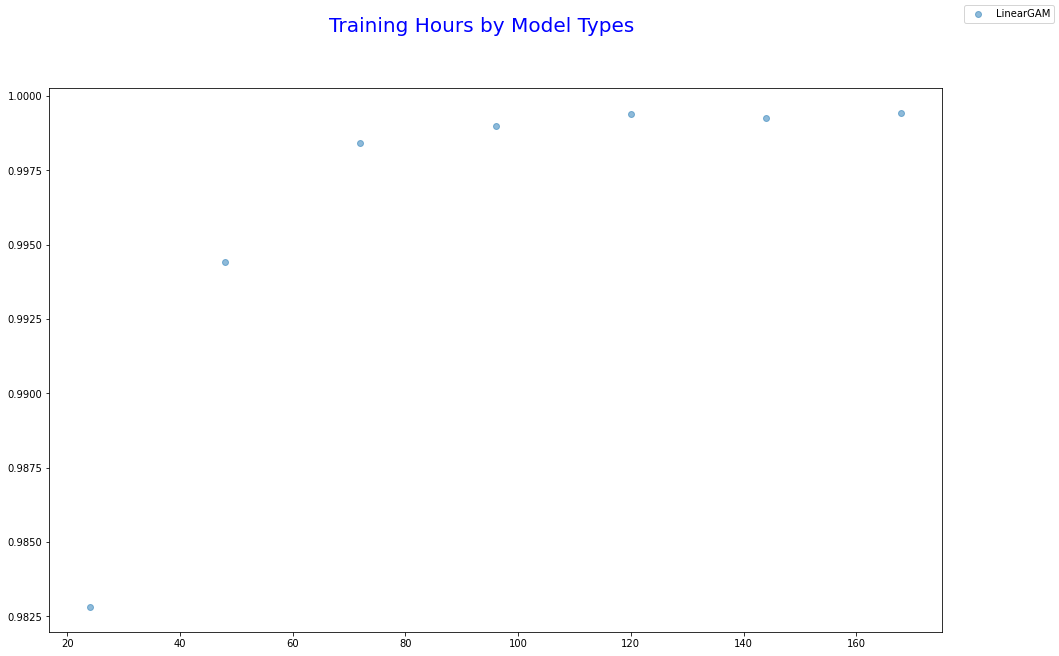

In [159]:
_df = ModelInventory().all_df

fig, subplot = plt.subplots(nrows=1, ncols=1, figsize=(16,10))
fig.suptitle(f"Training Hours by Model Types", fontsize=20, c='b')

for mtype in _df.model_type.unique():
    if mtype == 'PoissonGAM':
        continue
    __df = _df[_df.model_type==mtype].sort_values(by='hours_in_training')
    subplot.scatter(__df.hours_in_training, __df.score, alpha=.5, label=mtype)
    
fig.legend();

In [160]:
def plot_preds(m: ModelConfig, test_mode=True):
    
    d = m.data_config

    if test_mode:
        from_date = d.test_df.time_stamp.min().isoformat()
    else:
        from_date = d.test_df.time_stamp.max().isoformat()
    
    pred_df = pd.DataFrame(m.predict(from_date))
    
    fig, subplot = plt.subplots(nrows=1, ncols=1, figsize=(16,10))
    fig.suptitle(f"Best Model Actual vs. Prediction \n {m.modelclass.__name__}", fontsize=20, c='b')

    cmap = plt.get_cmap('Dark2')
    N = len(d.categories)
    for i, c in enumerate(d.categories):
        _act_df = d.test_df[d.test_df.class_name == c]
        _pred_df = pred_df[pred_df.class_name == c]
        color = cmap(float(i)/N)
        subplot.scatter(_act_df.time_stamp, _act_df.rate, alpha=.5, color=color)
        subplot.plot(_act_df.time_stamp, _act_df.rate, label=f"{c} actual", lw=1, ls='--', alpha=.5, c=color)
        subplot.plot(_pred_df.time_stamp, _pred_df['count'], label=f"{c} pred", lw=2, c=color)
        subplot.grid(linestyle='--', alpha=.5, linewidth=.7)
        subplot.legend()

    plt.show()

In [165]:
model_files = ModelInventory().all_df.sort_values(by='score').file_name.values

In [166]:
model_files

array(['MyMonitor_60_24_48_LinearGAM', 'MyMonitor_60_48_48_LinearGAM',
       'MyMonitor_60_72_48_LinearGAM', 'MyMonitor_60_96_48_LinearGAM',
       'MyMonitor_60_144_48_LinearGAM', 'MyMonitor_60_120_48_LinearGAM',
       'MyMonitor_60_168_48_LinearGAM'], dtype=object)

STRING PREDICTIONS
MODEL CONFIG:
Model                    : LinearGAM
R2                       : 0.9828158841109074
Train Date               : 2020-11-01
monitor_name             : MyMonitor
interval                 : 60
hours_in_training        : 24
hours_in_prediction      : 48
string_predictor_columns : ['class_code', 'weekday', 'hour']
response_columns         : ['rate']
source_data_from_date    : 2020-10-01T00:00:00



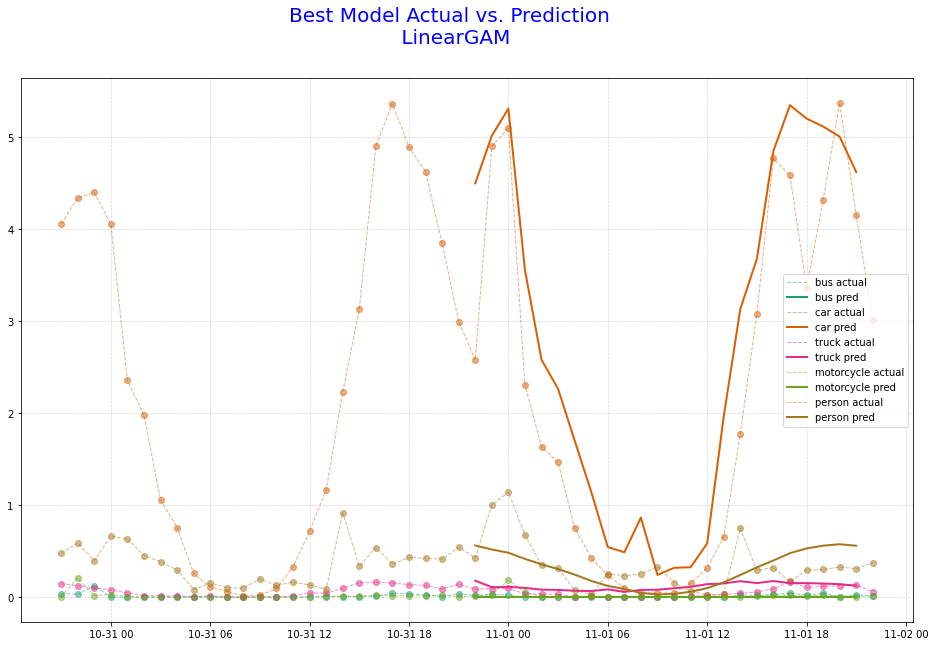

STRING PREDICTIONS
MODEL CONFIG:
Model                    : LinearGAM
R2                       : 0.9944274340040856
Train Date               : 2020-11-01
monitor_name             : MyMonitor
interval                 : 60
hours_in_training        : 48
hours_in_prediction      : 48
string_predictor_columns : ['class_code', 'weekday', 'hour']
response_columns         : ['rate']
source_data_from_date    : 2020-10-01T00:00:00



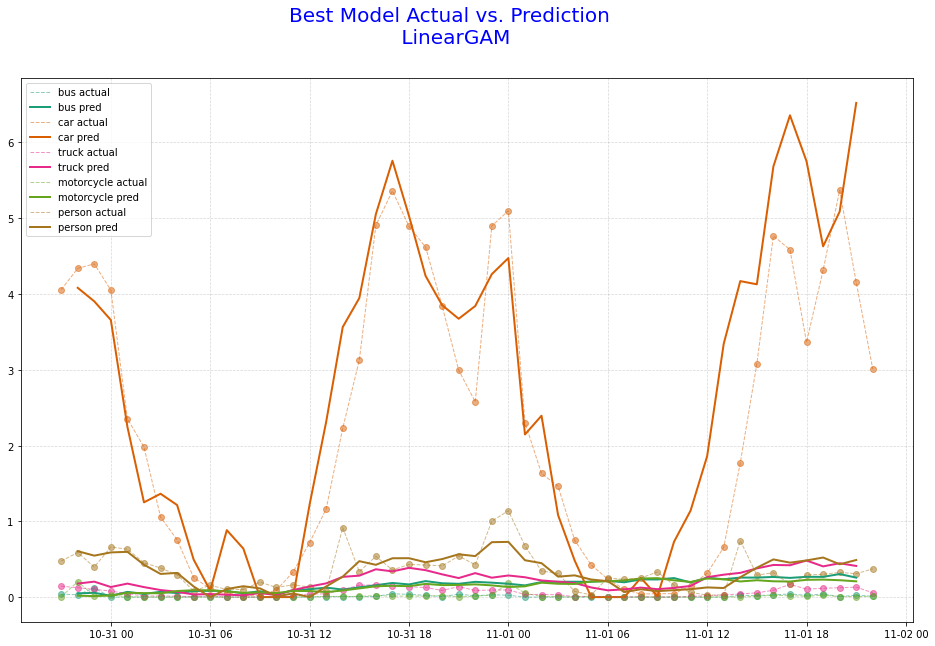

STRING PREDICTIONS
MODEL CONFIG:
Model                    : LinearGAM
R2                       : 0.9984141171222254
Train Date               : 2020-11-01
monitor_name             : MyMonitor
interval                 : 60
hours_in_training        : 72
hours_in_prediction      : 48
string_predictor_columns : ['class_code', 'weekday', 'hour']
response_columns         : ['rate']
source_data_from_date    : 2020-10-01T00:00:00



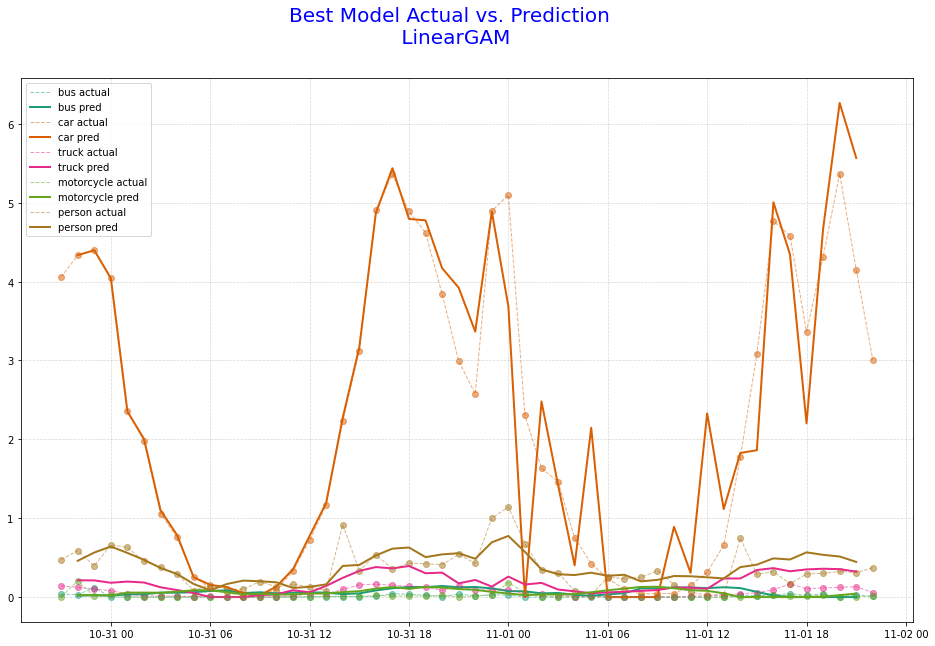

STRING PREDICTIONS
MODEL CONFIG:
Model                    : LinearGAM
R2                       : 0.9989995744613668
Train Date               : 2020-11-01
monitor_name             : MyMonitor
interval                 : 60
hours_in_training        : 96
hours_in_prediction      : 48
string_predictor_columns : ['class_code', 'weekday', 'hour']
response_columns         : ['rate']
source_data_from_date    : 2020-10-01T00:00:00



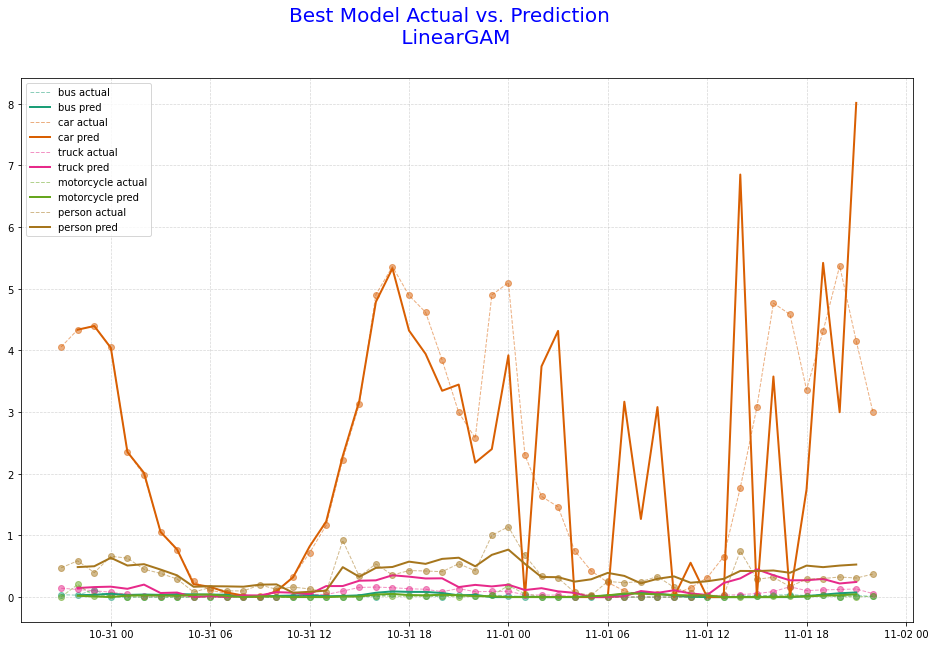

STRING PREDICTIONS
MODEL CONFIG:
Model                    : LinearGAM
R2                       : 0.9992579877248043
Train Date               : 2020-11-01
monitor_name             : MyMonitor
interval                 : 60
hours_in_training        : 144
hours_in_prediction      : 48
string_predictor_columns : ['class_code', 'weekday', 'hour']
response_columns         : ['rate']
source_data_from_date    : 2020-10-01T00:00:00



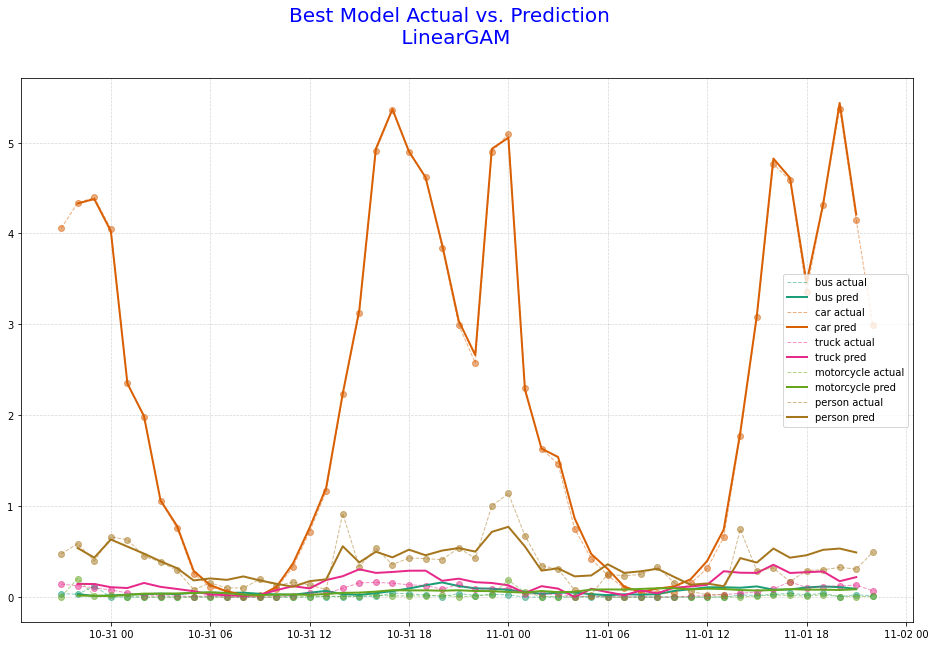

STRING PREDICTIONS
MODEL CONFIG:
Model                    : LinearGAM
R2                       : 0.9993981658951068
Train Date               : 2020-11-01
monitor_name             : MyMonitor
interval                 : 60
hours_in_training        : 120
hours_in_prediction      : 48
string_predictor_columns : ['class_code', 'weekday', 'hour']
response_columns         : ['rate']
source_data_from_date    : 2020-10-01T00:00:00



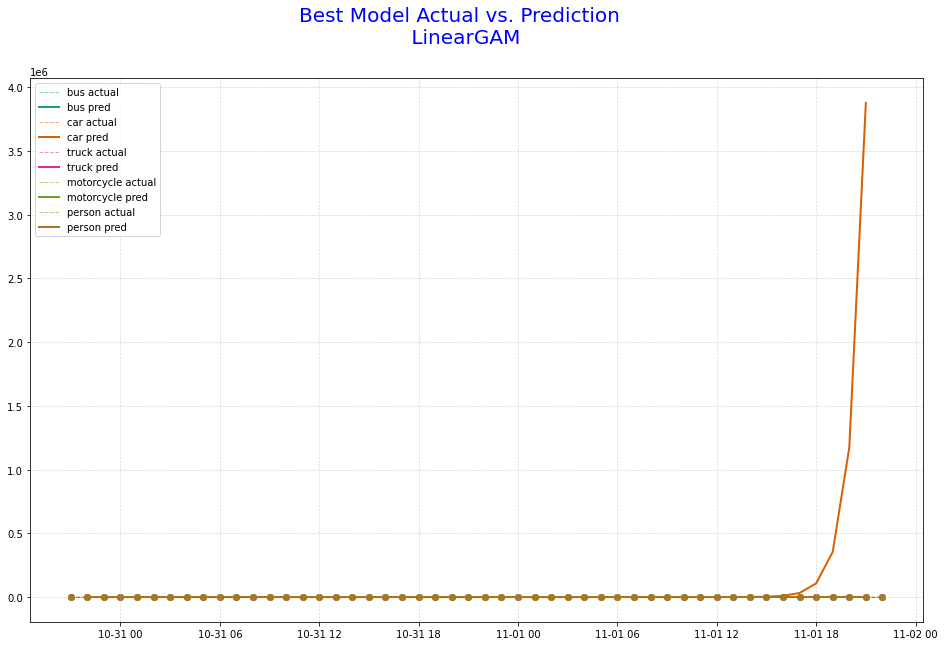

STRING PREDICTIONS
MODEL CONFIG:
Model                    : LinearGAM
R2                       : 0.9994231133888589
Train Date               : 2020-11-01
monitor_name             : MyMonitor
interval                 : 60
hours_in_training        : 168
hours_in_prediction      : 48
string_predictor_columns : ['class_code', 'weekday', 'hour']
response_columns         : ['rate']
source_data_from_date    : 2020-10-01T00:00:00



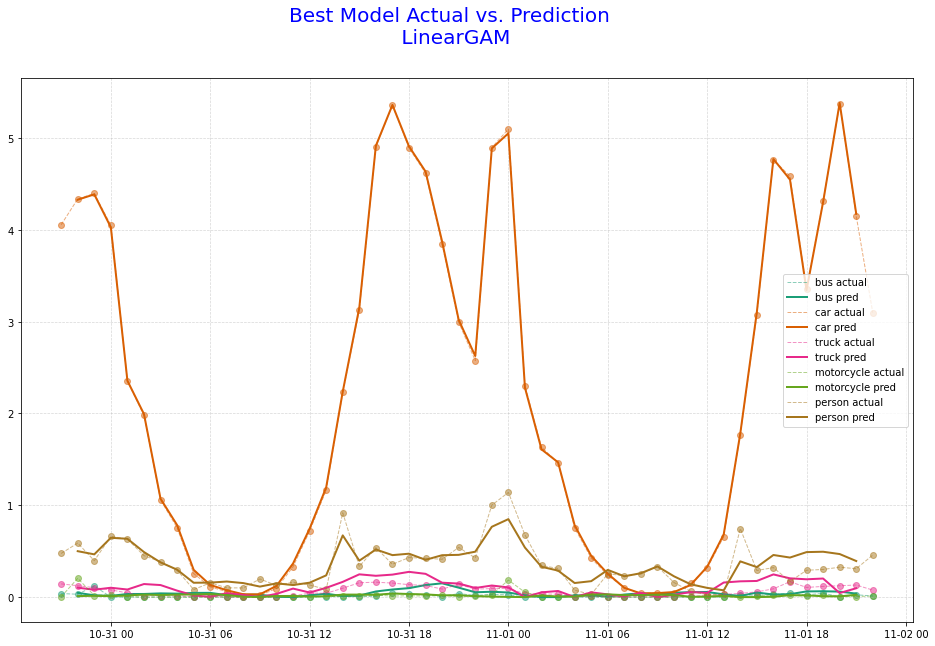

In [167]:
# m1 = mi.get_by_filename(model_files[3])
for mfile in model_files:
    plot_preds(ModelInventory().get_by_filename(mfile), test_mode=True)

## train.py

In [5]:
import numpy as np
from pygam import LinearGAM, s, f
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import pandas as pd

# from .model_config import ModelConfig
# from .model_inventory import ModelInventory


def execute_grid_search(m_config, model, param_search) -> dict:
    results = {}

    _tr_x, _tr_y, _te_x, _te_y = m_config.get_train_test_split()

    print("Evaluating Model")
    print(f"Hours in Training: {m_config.hours_in_training}")
    print(f"Hours in Prediction: {m_config.hours_in_prediction}")
    print(f"Interval in Minutes: {m_config.interval}")
    print(f"Start Training from UTC: {m_config.from_date_utc}")

    # LinerGAM is not a a scikit model and will be handled separately.
    # The only pramter we use here is the lam (aka - smoother)
    if model.__class__.__name__ == "LinearGAM":
        best_score = 0
        prev_score = 0
        prev_best_score = 0
        best_lam = 0
        for lam in param_search.get('lam'):
            terms = None
            for i, c in enumerate(_tr_x.columns):
                if c.startswith('-') or c.startswith('+'):
                    if terms == None:
                        terms = s(i, lam=lam)
                    else:
                        terms += s(i, lam=lam)
                else:
                    if terms == None:
                        terms = f(i)
                    else:
                        terms += f(i)
            _m = LinearGAM(terms=terms)
            y_pred = np.clip(_m.fit(_tr_x, _tr_y).predict(_te_x), a_min=0, a_max=None)
            _score = r2_score(y_true=_te_y, y_pred=y_pred)

            if _score > best_score:
                prev_best_score = best_score
                best_score = _score
                best_lam = lam
                best_model = _m

            print(f"lam: {lam:5}  r2: {_score}")
            if _score - prev_score <= .001 or _score < prev_best_score:
                break

            prev_score = _score

        best_params = f"\tlam: {best_lam}"

    else:
        tscv = TimeSeriesSplit(n_splits=8)
        gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring='r2', verbose=0, n_jobs=-1)
        gsearch.fit(_tr_x, _tr_y)
        best_model = gsearch.best_estimator_
        y_pred = np.clip(best_model.predict(_te_x), a_min=0, a_max=None)
        best_score = r2_score(y_true=_te_y, y_pred=y_pred)
        best_params = f"\t{' | '.join([f'{p}: {str(getattr(best_model, p))}' for p in param_search])}"

    print()
    print(model.__class__.__name__)
    print(f"Train Cols: {[c for c in _tr_x.columns if not (c.startswith('-'))]}")
    print(f"\tBest Model's R2 Score: {round(best_score, 4)}")
    print(f"\tBest Parameters: {best_params}")
    print(f"\tScore By Class:")
    for class_name in m_config.categories:
        idxs = _te_x[_te_x.class_code == m_config.get_code(class_name)].index
        r2 = r2_score(y_true=_te_y[idxs], y_pred=y_pred[idxs])
        print(f"\t\t{class_name:10}: {round(r2, 4):>6}")
        results.update({class_name: r2})

    results.update({'best_model': best_model})
    results.update({'best_overall_score': best_score})

    return {model.__class__.__name__: results}


def get_best_model(m_config):
    models_to_evaluate = []

    models_to_evaluate.append({'model': LinearGAM(),
                               'param_search': {
                                   'lam': [.1, 10, 50, 100, 400, 800, 1200, 1600, 2000, 2500],
                               }
                               })

    #     models_to_evaluate.append( {'model': RandomForestRegressor(n_jobs=-1, random_state=0),
    #                                 'param_search': {
    #                                                  'n_estimators': [10, 50, 100, 150],
    #                                                  'max_features': ['auto'], #, 'sqrt', 'log2'], -> the best scores are always auto
    #                                                  'max_depth' : [i for i in range(5,15)]
    #                                                 }
    #                                })

    #     models_to_evaluate.append( {'model': GradientBoostingRegressor(random_state=0),
    #                                 'param_search': {
    #                                                  'n_estimators': [20, 50, 100],
    #                                                  'learning_rate' : [.05, .1, .5, 1],
    #                                                  'loss' : ['ls', 'lad', 'huber', 'quantile']
    #                                                 }
    #                                })

    evaluation_results = {}
    for m in models_to_evaluate:
        r = execute_grid_search(m_config, m.get('model'), m.get('param_search'))
        evaluation_results.update(r)

    results_df = pd.DataFrame(evaluation_results).T
    return results_df[results_df.best_overall_score == results_df.best_overall_score.max()]['best_model'][0]


def train_and_save(monitor_name, interval,
                   hours_in_training, hours_in_prediction,
                   string_predictor_columns,
                   source_data_from_date: str = None):
    """ Train model """

    m_config = ModelConfig(monitor_name=monitor_name,
                           interval=interval,
                           hours_in_training=hours_in_training,
                           hours_in_prediction=hours_in_prediction,
                           string_predictor_columns=string_predictor_columns,
                           source_data_from_date=source_data_from_date)

    trained_model: LinearGAM = get_best_model(m_config)

    filename = m_config.save(trained_model)

    ModelInventory().add(filename=filename, model_config=m_config, trained_model=trained_model)

    return filename


# def retrain_by_filename(filename: str):
#     m_config = ModelConfig.get_config_by_filename(filename)
#     if m_config is None:
#         return
#     trained_model: LinearGAM = get_best_model(m_config)
#     filename = m_config.save(trained_model)
#     # update the inventory with the newly trained model
#     return ModelInventory().add(filename=filename, model_config=m_config, trained_model=trained_model)


# def setup_default_models(monitor_name):
#     """ Trains and saves pre-determined default models that are ready for making predictions.
#     Ensures that there is at lesat one model to use for forecasting. """

#     default_models = []
#     filenames = []
#     model = {'monitor_name': monitor_name,
#              'interval': 60,
#              'hours_in_training': 24,
#              'hours_in_prediction': 24,
#              'string_predictor_columns': ['class_code', 'weekday', 'hour'],
#              'source_data_from_date': '2020-10-01'}
#     default_models.append(model)

#     model = {'monitor_name': monitor_name,
#              'interval': 60,
#              'hours_in_training': 48,
#              'hours_in_prediction': 24,
#              'string_predictor_columns': ['class_code', 'weekday', 'hour'],
#              'source_data_from_date': '2020-10-01'}
#     default_models.append(model)

#     for m in default_models:
#         c = ModelConfig(**m)
#         if not c.is_saved():
#             filenames.append(train_and_save(**m))


def retrain_all(monitor_name):
    models = ModelInventory().get_inventory_listing(monitor_name=monitor_name)
    for fname in models:
        retrain_by_filename(fname)


# immediately ensure that at least one 'fresh' model is available
# setup_default_models('MyMonitor')


In [10]:
MODELS_DIR = '.'
setup_default_models('MyMonitor')

Evaluating Model
Hours in Training: 24
Hours in Prediction: 24
Interval in Minutes: 60
Start Training from UTC: 2020-10-01 06:00:00+00:00
lam:   0.1  r2: 0.9591841853776157
lam:    10  r2: 0.9721173897632163
lam:    50  r2: 0.9718240051349563

LinearGAM
Train Cols: ['class_code', 'weekday', 'hour']
	Best Model's R2 Score: 0.9721
	Best Parameters: 	lam: 10
	Score By Class:
		bus       : -2.7626
		car       : 0.9509
		truck     : 0.4497
		motorcycle: -2.2347
		person    :  0.714
Evaluating Model
Hours in Training: 48
Hours in Prediction: 24
Interval in Minutes: 60
Start Training from UTC: 2020-10-01 06:00:00+00:00
lam:   0.1  r2: 0.9380468147917506
lam:    10  r2: 0.9672567906015194
lam:    50  r2: 0.9692056167853852
lam:   100  r2: 0.9688925252342778

LinearGAM
Train Cols: ['class_code', 'weekday', 'hour']
	Best Model's R2 Score: 0.9692
	Best Parameters: 	lam: 50
	Score By Class:
		bus       : -2.257
		car       : 0.9444
		truck     : 0.4879
		motorcycle: -1.592
		person    : 0.7237


<h2>Model Evaluation</h2>
First, we evaluate models trained with each individual classs name, one at a time.
These models will not take into account any correlation between rates from different objects that are detected.

In [28]:
model_config = ModelDataConfig(monitor_name='MyMonitor',
                               interval=60,
                               hours_in_training=24,
                               hours_in_prediction=24,
                               source_data_from_date="2020-09-27",
                               categories=['truck', 'bus', 'car', 'motorcycle', 'person'])

In [29]:
test_models = []
test_models.append(('LinReg', LinearRegression()))
# test_models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
# test_models.append(('KNN', KNeighborsRegressor(n_neighbors=shifts))) 
test_models.append(('DecTree', DecisionTreeRegressor(max_depth= 10, random_state=0)))
test_models.append(('RF', RandomForestRegressor(n_jobs=-1, n_estimators = 150, random_state=0))) 
test_models.append(('GradientBoost', GradientBoostingRegressor(n_estimators = 150, random_state=0))) 
# test_models.append(('AdaBoost', AdaBoostRegressor(n_estimators = 150, random_state=0))) 
# test_models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
test_models.append(('LinearGAM', LinearGAM()))


In [30]:
def evaluate(m_config, _models):
        
    _tr_x, _tr_y, _te_x, _te_y = m_config.get_train_test_split()
       
    print(f"Train Cols: {[c for c in m_config.predictor_columns if not c.startswith('-')]}")
    
    for name, model in _models:
        if name == 'LinearGAM':
            terms = None
            for i, c in enumerate(_tr_x.columns):
                if c.startswith('-'):
                    if terms == None:
                        terms = s(i)
                    else:
                        terms += s(i)
                else:
                    if terms == None:
                        terms = f(i)
                    else:
                        terms += f(i)
            m = LinearGAM(terms=terms).fit(_tr_x, _tr_y)
            y_pred = np.clip(m.predict(_te_x), a_min=0, a_max=None)
            r2 = r2_score(y_true=_te_y,y_pred=y_pred)
            print(f"{name:15}: r2 mean-> {round(r2, 3):>6}")
        else:
            tscv = TimeSeriesSplit(n_splits=8)  
            cv_results = cross_val_score(model, _tr_x, _tr_y, cv=tscv, scoring='r2', n_jobs=-1)
            print(f"{name:15}: r2 mean-> {round(cv_results.mean(), 3):>6} std-> {round(cv_results.std(), 3):>6}")

In [31]:
# defulat 'class_code' indicator column
%time evaluate(model_config, test_models)

Train Cols: ['class_code']
LinReg         : r2 mean->  0.633 std->  0.608
DecTree        : r2 mean->  0.376 std->  0.446
RF             : r2 mean->  0.625 std->  0.354
GradientBoost  : r2 mean->  0.527 std->  0.572
LinearGAM      : r2 mean->  0.959
CPU times: user 1.57 s, sys: 237 ms, total: 1.81 s
Wall time: 6.24 s


In [32]:
model_config.set_predictor_columns(['class_code', 'weekday'])
%time evaluate(model_config, test_models)

Train Cols: ['class_code', 'weekday']
LinReg         : r2 mean->  0.415 std->  1.179
DecTree        : r2 mean->  0.343 std->  0.482
RF             : r2 mean->   0.62 std->  0.353
GradientBoost  : r2 mean->  0.516 std->  0.581
LinearGAM      : r2 mean->   0.96
CPU times: user 1.81 s, sys: 264 ms, total: 2.07 s
Wall time: 5.38 s


In [33]:
model_config.set_predictor_columns(['class_code', 'weekday', 'hour', 'minute'])
%time evaluate(model_config, test_models)

Train Cols: ['class_code', 'weekday', 'hour', 'minute']
LinReg         : r2 mean->  0.413 std->  1.187
DecTree        : r2 mean->  0.329 std->  0.513
RF             : r2 mean->  0.624 std->  0.351
GradientBoost  : r2 mean->  0.556 std->  0.502
LinearGAM      : r2 mean->  0.961
CPU times: user 1.76 s, sys: 221 ms, total: 1.98 s
Wall time: 6.09 s


In [34]:
# set the best performing combination of predictors
model_config.set_predictor_columns(['class_code', 'weekday', 'hour', 'minute'])

<h3>Quick Evaluation Results</h3>
Our best performers are the RandomForest, Gradient Descent and Linear GAM models.  The RandomForest and Gradient Descent scores are notably low as a result of how scikit scores models evaluated using cross validation and the fact that we are using a TimeSeries split of folds for the cross validation.  When weook closer at these models, we can expect to see higher   For now, we just want to do a quick validation to see models may perform best afater we do some model prapmeter fine-tuning.

<h3>Fine-Tuning</h3>
Let's fine-tune the best performers: RandomForest, GadientBoost, LinearGAM

In [35]:
def execute_grid_search(m_config, model, param_search) -> dict:
    results = {}
    
    _tr_x, _tr_y, _te_x, _te_y = m_config.get_train_test_split()
        
    # LinerGAM is not a ascikit model and will be handled separately.
    # The only pramter we use here is the lam (aka - smoother)
    if model.__class__.__name__ == "LinearGAM":
        best_score = 0
        for lam in param_search.get('lam'):
            terms = None
            for i, c in enumerate(_tr_x.columns):
                if c.startswith('-') or c.startswith('+'):
                    if terms == None:
                        terms = s(i, lam=lam)
                    else:
                        terms += s(i, lam=lam)
                else:
                    if terms == None:
                        terms = f(i)
                    else:
                        terms += f(i)
            _m = LinearGAM(terms=terms)
            y_pred = np.clip(_m.fit(_tr_x, _tr_y).predict(_te_x), a_min=0, a_max=None)
            _score = r2_score(y_true=_te_y,y_pred=y_pred)
            if _score > best_score:
                best_score = _score
                best_lam = lam
                best_model = _m
            print(f"lam: {lam:5}  r2: {_score}")
        
        best_params = f"\tlam: {best_lam}"
        
    else:
        tscv = TimeSeriesSplit(n_splits=8)
        gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = 'r2', verbose=0, n_jobs=-1)
        gsearch.fit(_tr_x, _tr_y)
        best_model = gsearch.best_estimator_
        y_pred = np.clip(best_model.predict(_te_x), a_min=0, a_max=None)
        best_score = r2_score(y_true=_te_y, y_pred=y_pred)
        best_params = f"\t{' | '.join([f'{p}: {str(getattr(best_model, p))}' for p in param_search])}"

    print()
    print(model.__class__.__name__)
    print(f"Train Cols: {[c for c in _tr_x.columns if not (c.startswith('-'))]}")
    print(f"\tBest Model's R2 Score: {round(best_score, 4)}")
    print(f"\tBest Parameters: {best_params}")
    print(f"\tScore By Class:")
    for class_name in m_config.categories:
        idxs = _te_x[_te_x.class_code == m_config.get_code(class_name)].index
        r2 = r2_score(y_true=_te_y[idxs], y_pred=y_pred[idxs])
        print(f"\t\t{class_name:10}: {round(r2, 4):>6}")
        results.update({class_name: r2})
        
    results.update({'best_model': best_model})
    results.update({'best_overall_score': best_score})
    
    return {model.__class__.__name__: results}

<h3>Conclusion</h3>
After picking our best 3 overall performers and evaluating them for predicting each class, we observe that the parametrice models perform better despit an overall lower score than the LinearGAM.  Of the non-parametric models, the GradientBooster has a slight advantage over the RandomForestRegressor.

Based on pure numerical results, the GradientBooster is the best, but since we see varying results, I consider the comparisons inconclusice and will choose to visualize all models before drawing a final conclusion.

<h3>Visualize Model Predictions</h3>
These models only predict the next minute interval values. This is not very useful.  We will string predictions together to create the prediction for an entire day.

In [36]:
def get_best_model(m_config):
    models_to_evaluate = []

    models_to_evaluate.append({'model': LinearGAM(),
                               'param_search': { 
                                               #'lam': [500, 725, 750, 775, 800, 825, 850, 875, 1000],
                                                'lam': [.1, 10, 50, 100, 400, 800, 1200, 1600, 2000, 2500],
                                               }
                              })

#     models_to_evaluate.append( {'model': RandomForestRegressor(n_jobs=-1, random_state=0),
#                                 'param_search': { 
#                                                  'n_estimators': [10, 50, 100, 150],
#                                                  'max_features': ['auto'], #, 'sqrt', 'log2'], -> the best scores are always auto
#                                                  'max_depth' : [i for i in range(5,15)]
#                                                 }
#                                })

#     models_to_evaluate.append( {'model': GradientBoostingRegressor(random_state=0),
#                                 'param_search': { 
#                                                  'n_estimators': [20, 50, 100],
#                                                  'learning_rate' : [.05, .1, .5, 1],
#                                                  'loss' : ['ls', 'lad', 'huber', 'quantile']
#                                                 }
#                                })

    evaluation_results = {}
    for m in models_to_evaluate:
        r = execute_grid_search(m_config, m.get('model'), m.get('param_search'))
        evaluation_results.update(r)

    results_df = pd.DataFrame(evaluation_results).T
    return results_df[results_df.best_overall_score == results_df.best_overall_score.max()]['best_model'][0]


In [37]:
def string_predictions(m_config: ModelDataConfig, trained_model, from_date=None):

    n_intervals = m_config.hours_in_training * int(60/m_config.interval)
    n_predictors = len([c for c in m_config.predictor_columns if not c.startswith('-')])

    X, time_zero = m_config.get_seed_observation(on_date=from_date)
    
    # String predictions
    for i in range(1, n_intervals+1):
        r = list(range(n_predictors)) + list(range(len(X.columns)-n_intervals, len(X.columns)))
        X[f"+{i}"] = np.clip(trained_model.predict(X.iloc[:, r]), a_min=0, a_max=None)

    # Get initial DF with prediction columns
    r = list(range(n_predictors)) + list(range(len(X.columns) - n_intervals, len(X.columns)))
    X = X.iloc[:, r]
    
    # insert the class name
    idx = int(np.where(X.columns == 'class_code')[0][0])
    X.insert(idx+1, 'class_name', X['class_code'].apply(lambda s: m_config.get_category(s)))
    
    # rename future period columns to timestamp values
    time_stamps = [time_zero + pd.Timedelta(f'{m_config.interval * i} minutes') for i in range(1, n_intervals+1)]
    col_mapper = {old_c:time_stamps[int(old_c)-1] for old_c in X.columns if old_c.startswith('+')}
    
    id_vars = [c for c in X.columns if not c.startswith('+')]
    
    X.rename(columns=col_mapper, inplace=True)
    
    X = pd.melt(X, id_vars=id_vars, var_name='time_stamp', value_name='rate')
    
    X = m_config._add_time_features(X)
    
    return X

In [38]:
def plot_preds(m_config, trained_model, test_mode=True):

    if test_mode:
        from_date = m_config.test_df.time_stamp.min().isoformat()
    else:
        from_date = m_config.test_df.time_stamp.max().isoformat()
    
    pred_df = string_predictions(m_config=m_config,
                                 trained_model=trained_model, 
                                 from_date=from_date)
    
    fig, subplot = plt.subplots(nrows=1, ncols=1, figsize=(16,10))
    fig.suptitle(f"Best Model Actual vs. Prediction \n {trained_model.__class__.__name__}", fontsize=20, c='b')

    cmap = plt.get_cmap('Dark2')
    N = len(m_config.categories)
    for i, c in enumerate(m_config.categories):
        _act_df = m_config.test_df[m_config.test_df.class_name == c]
        _pred_df = pred_df[pred_df.class_name == c]
        color = cmap(float(i)/N)
        subplot.scatter(_act_df.time_stamp, _act_df.rate, alpha=.5, color=color)
        subplot.plot(_act_df.time_stamp, _act_df.rate, label=f"{c} actual", lw=1, ls='--', alpha=.5, c=color)
        subplot.plot(_pred_df.time_stamp, _pred_df.rate, label=f"{c} pred", lw=2, c=color)
        subplot.grid(linestyle='--', alpha=.5, linewidth=.7)
        subplot.legend()

    plt.show()


lam:   0.1  r2: 0.9589092621732935
lam:    10  r2: 0.9665345591464324
lam:    50  r2: 0.969904863533102
lam:   100  r2: 0.9712207431045244
lam:   400  r2: 0.9730096404983144
lam:   800  r2: 0.9735854265999797
lam:  1200  r2: 0.9738837337017403
lam:  1600  r2: 0.9740873802206115
lam:  2000  r2: 0.9742427061883601
lam:  2500  r2: 0.9743965072815831

LinearGAM
Train Cols: ['class_code', 'weekday', 'hour', 'minute']
	Best Model's R2 Score: 0.9744
	Best Parameters: 	lam: 2500
	Score By Class:
		truck     : 0.7218
		bus       : -1.3202
		car       : 0.9473
		motorcycle: -7.2894
		person    : 0.9487


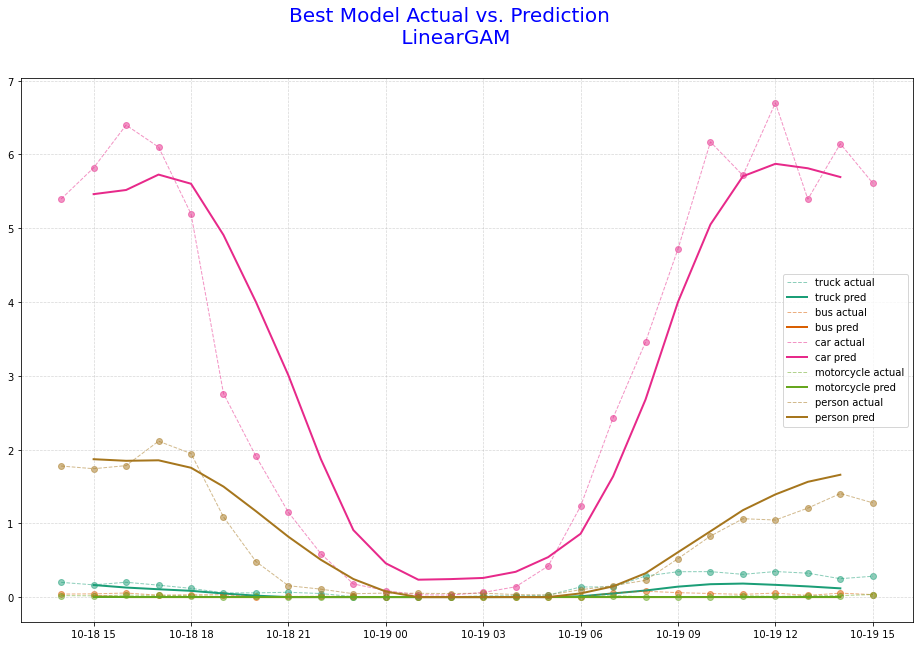

In [39]:
plot_preds(model_config, get_best_model(model_config), test_mode=True)

<h3>Result</h3>
Since the models only predict the next 15 minute increment, we use a stringing process to build a day's predictions by creating successive predictions.  After reviewing several different time periods, the LinearGAM performed the most consistely well.  Although, the RandomForest and GradientDescent models also did well, they can yield unreasonable results during periods of low(RF) or high(GD) activity.

We will choose the LinearGAM as the preferred model for this data set.

In [40]:
def create_forecast(monitor_name, interval, hours_in_training, hours_in_prediction, 
                    source_data_from_date:str=None, categories=None):

    m_config = ModelDataConfig(monitor_name=monitor_name,
                               interval=interval,
                               hours_in_training=hours_in_training,
                               hours_in_prediction=hours_in_prediction,
                               source_data_from_date=source_data_from_date)
    
    pred_df = string_predictions(m_config=m_config,
                                 trained_model=get_best_model(m_config),
                                 from_date=None)
    
    pred_df = pred_df[pred_df.class_name.isin(categories)][['time_stamp', 'class_name', 'rate']]

    return pred_df.to_dict(orient='list')

In [41]:
fc_dict = create_forecast(monitor_name='MyMonitor',
                          interval=60, 
                          hours_in_training=24, hours_in_prediction=24,
                          source_data_from_date="2020-09-27",
                          categories=['car', 'truck'])


lam:   0.1  r2: 0.9488345067566172
lam:    10  r2: 0.956496309745564
lam:    50  r2: 0.9607366932517746
lam:   100  r2: 0.9627156490424509
lam:   400  r2: 0.9656181057253146
lam:   800  r2: 0.9665136601176361
lam:  1200  r2: 0.9669627212676967
lam:  1600  r2: 0.9672679315215925
lam:  2000  r2: 0.9675028795146691
lam:  2500  r2: 0.9677391351265436

LinearGAM
Train Cols: ['class_code']
	Best Model's R2 Score: 0.9677
	Best Parameters: 	lam: 2500
	Score By Class:
		car       : 0.9439
		truck     : 0.8857


In [42]:
pd.DataFrame(fc_dict)

,class_code,class_name,time_stamp,rate,year,month,day,weekday,hour,minute,day_minute,week_minute
0,0,car,2020-10-19 16:00:00,5.929519,2020,10,19,0,16,0,960,960
1,1,truck,2020-10-19 16:00:00,0.243955,2020,10,19,0,16,0,960,960
2,0,car,2020-10-19 17:00:00,5.814099,2020,10,19,0,17,0,1020,1020
3,1,truck,2020-10-19 17:00:00,0.196961,2020,10,19,0,17,0,1020,1020
4,0,car,2020-10-19 18:00:00,5.099854,2020,10,19,0,18,0,1080,1080
5,1,truck,2020-10-19 18:00:00,0.155287,2020,10,19,0,18,0,1080,1080
6,0,car,2020-10-19 19:00:00,3.897891,2020,10,19,0,19,0,1140,1140
7,1,truck,2020-10-19 19:00:00,0.125308,2020,10,19,0,19,0,1140,1140
8,0,car,2020-10-19 20:00:00,2.636039,2020,10,19,0,20,0,1200,1200
9,1,truck,2020-10-19 20:00:00,0.094631,2020,10,19,0,20,0,1200,1200
